# Implémentation : "Object Removal by Exemplar-Based Inpainting"

_Article par : A. Criminisi, P. Pérez K. Toyama_

_Implémentation : Abdennour Kerboua_

## Recueil du contour et calcul de la source et cible

### Importations

In [10]:
import cv2
import numpy as np
from scipy.ndimage import convolve
import time
import matplotlib.pyplot as plt

### Selection contour

Sélectionnez les points du contour en cliquant. Appuyez sur 'q' lorsque vous avez terminé.


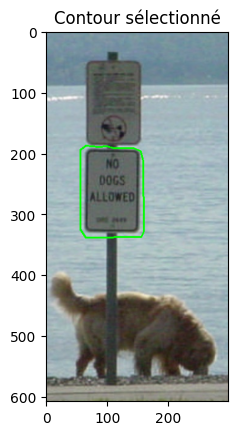

In [115]:
img_path = 'image_chien.jpeg'
contour = []

def select_point(event, x, y, flags, param):
    global contour
    if event == cv2.EVENT_LBUTTONDOWN:
        contour.append((x, y))
        cv2.circle(img_copy, (x, y), 3, (0, 255, 0), -1)
        cv2.imshow("Image", img_copy)

def close_contour(contour):
    if contour[0] != contour[-1]:
        contour.append(contour[0])
    return contour

def get_pixels_from_contour(contour):
    mask = np.zeros_like(img_gray)
    cv2.polylines(mask, [np.array(contour)], isClosed=True, color=255, thickness=1)
    pixels = np.column_stack(np.where(mask == 255))
    return pixels

img = cv2.imread(img_path)

if img is None:
    raise ValueError("L'image n'a pas pu être chargée. Assurez-vous que le chemin est correct.")

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_copy = img.copy()

cv2.imshow("Image", img_copy)
cv2.setMouseCallback("Image", select_point)

print("Sélectionnez les points du contour en cliquant. Appuyez sur 'q' lorsque vous avez terminé.")

while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

if len(contour) >= 3:
    closed_contour = close_contour(contour)
    pixels = get_pixels_from_contour(closed_contour)

    #print("Contour sélectionné :", closed_contour)
    #print("Pixels du contour :", pixels)

    img_with_contour = img.copy()
    cv2.polylines(img_with_contour, [np.array(closed_contour)], isClosed=True, color=(0, 255, 0), thickness=2)

    plt.imshow(cv2.cvtColor(img_with_contour, cv2.COLOR_BGR2RGB))
    plt.title('Contour sélectionné')
    plt.show()
else:
    print("Sélection incomplète : au moins 3 points sont nécessaires pour un contour.")

### Calcul de la surface cible et source

In [116]:
def find_surface_and_complement(img_shape, contour):
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    #plt.imshow(mask,cmap="gray")
    cv2.fillPoly(mask, np.array([contour]), 255)
    #plt.figure()
    #plt.imshow(mask,cmap="gray")
    surface_pixels = np.column_stack(np.where(mask == 255))
    complement_pixels = np.column_stack(np.where(mask == 0))

    return surface_pixels, complement_pixels

pixels_rev= [[pix[1],pix[0]] for pix in pixels]

cible, source = find_surface_and_complement(img.shape,pixels_rev)
img_in_progress = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
mask = np.zeros(img_in_progress.shape)
for pix in source:
    mask[pix[0],pix[1]]=1
for pix in cible:
    img_in_progress[pix[0],pix[1]] = 0
plt.figure()
#plt.imshow(mask,cmap='gray')
contour = pixels
data_coeff = {}
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### **1a.** Caclul du front à chaque itération

In [117]:
def calculer_front():
    hauteur, largeur = mask.shape[:2]
    contour = []

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    for i in range(hauteur):
        for j in range(largeur):
            if mask[i, j][0] == 0:
                for di, dj in directions:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < hauteur and 0 <= nj < largeur:
                        if mask[ni, nj][0] ==1:
                            contour.append([i,j])
                            break

    return np.array(contour)

### **1b.** Calcul des priorités pour le contour

#### Calcul de la confiance pour un pixel $p$ donné et fonction de mise à jour pour le contour

In [113]:
def is_in_source(mask_cropped):
    return mask_cropped[mask_cropped==0].shape[0]==0

In [95]:
def init_confidence(source,priority):
    for pix in source:
            priority[pix[0],pix[1]] = 1
    return "Pixel source initialisés à 1"

def maj_confidence_pix(y,x,taille_patch,confidence):
    new_p = 0
    hauteur, largeur = confidence.shape
    tp2 = taille_patch//2
    tpcar = taille_patch**2
    for xprime in range(max(0,x - tp2),min(largeur,x+tp2+1)):
        for yprime in range(max(y - tp2,0),min(y+tp2+1,hauteur)):
            if mask[yprime,xprime,0]==1:
                new_p += confidence[yprime,xprime]
    confidence[y,x] = new_p/(tpcar)
    return

def maj_confidence_contour(contour,taille_patch,confidence):
    for pix in contour:
        y,x = pix[0],pix[1]
        maj_confidence_pix(y,x,taille_patch,confidence)
    return "Pixels du contour actualisés"

In [118]:
# Initialisations
confidence = np.zeros(img_gray.shape)
init_confidence(source,confidence)

'Pixel source initialisés à 1'

#### Calcul du data coefficient

In [97]:
def calculer_normales_front(masque):
    hauteur, largeur = masque.shape[:2]
    masque = masque[:,:,:1]
    gradient_x = np.zeros(masque.shape)
    gradient_y = np.zeros(masque.shape)
    for y in range(hauteur):
        for x in range(largeur):
            gradient_x[y,x] = masque[y,x] - masque[y,max(0,x-1)]
            gradient_y[y,x] = masque[y,x] - masque[max(0,y-1),x]
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    normal_x = gradient_x
    normal_y = gradient_y
    for i in range(normal_x.shape[0]):
        for j in range(normal_x.shape[1]):
                if magnitude[i,j] != 0:
                    normal_x[i,j] = normal_x[i,j]/magnitude[i,j]
                    normal_y[i,j] = normal_y[i,j]/magnitude[i,j]
    return normal_x, normal_y

def calculer_data(image, pixels,alpha=255,taille_patch=9):
    hauteur, largeur = image.shape[:2]
    sobel_x = np.array([[-1, 0, 1], 
                        [-2, 0, 2], 
                        [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], 
                        [0, 0, 0], 
                        [1, 2, 1]])
    gradient_x = convolve(image, sobel_x)
    gradient_y = convolve(image, sobel_y)
    for pix in contour:
        y,x = pix
        counter = 0.
        average_grad_x = 0.
        average_grad_y = 0.
        for i in range(max(0,y-taille_patch//2),min(hauteur,y+taille_patch//2+1)):
            for j in range(max(0,x-taille_patch//2),min(largeur,x+taille_patch//2+1)):
                mask_cropped = mask[max(0,i-1):min(hauteur,i+2),max(0,j-1):min(largeur,j+2)]
                if is_in_source(mask_cropped):
                    average_grad_x += gradient_x[i,j]
                    average_grad_y += gradient_y[i,j]
                    counter += 1.
        gradient_x[y,x] = average_grad_x/counter
        gradient_y[y,x] = average_grad_y/counter

    normal_x, normal_y = calculer_normales_front(mask)
    resultats = {}
    for (y, x) in pixels:
        grad_x = gradient_x[y, x]
        grad_y = gradient_y[y, x]
        norm_x,norm_y = normal_x[y,x],normal_y[y,x]
        produit_scalaire = grad_x * norm_x + grad_y * norm_y
        resultats[(y, x)] = np.abs(produit_scalaire)/alpha
    return resultats

### **2a.** Selection du pixel traité

In [119]:
def get_prior_pixel():
    pix = np.zeros([])
    priomax = float('-inf')
    for pixcand in contour:
        prio_cand = confidence[pixcand[0],pixcand[1]]
        if prio_cand >= priomax:
            pix = pixcand
            priomax=prio_cand
    return pix

### **2b.** Calcul du meilleur patch

##### _Calcul de la distance SSD (Sum of Squarred Distance)_

In [106]:
def distance(source,x_patch,y_patch,img,mask_cropped,taille_patch):
    tp2 = taille_patch//2
    patch = img[y_patch-tp2:y_patch+tp2+1,x_patch-tp2:x_patch+tp2+1]
    patch = patch.astype(np.int64)
    source = source.astype(np.int64)
    diff = source - patch
    ssd = diff**2
    ssd = ssd * mask_cropped
    res = np.sum(ssd)
    return res

In [107]:
def get_best_patch(img,x_patch,y_patch,taille_patch):
    hauteur, largeur = mask.shape[:2]
    distancemin = float('inf')
    tp2 = taille_patch//2
    x_opt, y_opt = taille_patch, taille_patch
    x_min,x_max = tp2,largeur-tp2
    y_min,y_max = tp2,hauteur-tp2
    mask_cropped_patch = mask[y_patch-tp2:y_patch+tp2+1, x_patch-tp2:x_patch+tp2+1]
    for y in range(y_min,y_max):
        for x in range(x_min,x_max):
            source = img[y-tp2:y+tp2+1, x-tp2:x+tp2+1]
            mask_cropped = mask[y-tp2:y+tp2+1, x-tp2:x+tp2+1]
            if is_in_source(mask_cropped):
                distance_cand = distance(source,x_patch,y_patch,img,mask_cropped_patch,taille_patch)
                if distance_cand < distancemin:
                    x_opt,y_opt = x,y
                    distancemin = distance_cand
    #print(x_opt,y_opt)
    #print(distancemin)
    return x_opt,y_opt

### **2b.** / **3.** Copie du patch et mise a jour des pixels remplis

In [99]:
def copie(x_source,y_source,x_patch,y_patch,img,taille_patch):
    tp2 = taille_patch//2
    nmb = 0
    for i in range(-tp2,tp2+1):
        for j in range(-tp2,tp2+1):
            if mask[y_patch+i,x_patch + j][0]==0:
                nmb+=1
                img[y_patch + i,x_patch + j] = img[y_source + i,x_source+j]
                confidence[y_patch + i,x_patch +j]=confidence[y_patch,x_patch]
                np.append(source,[y_patch,x_patch])
                mask[y_patch + i,x_patch + j] = 1
    #print("Nombre de pixels copiés",nmb)
    return nmb

## Algorithme final

In [120]:
from tqdm import tqdm
taille_patch=31
with tqdm(total=mask[mask==0].shape[0], desc="Traitement des pixels") as pbar:
    while mask[mask==0].shape[0] !=0:
        #t1 = time.time()
        maj_confidence_contour(contour,taille_patch,confidence)
        #indices_cont = [(pix[0],pix[1]) for pix in contour]
        #lignes, colonnes = zip(*indices_cont)
        #print(max(confidence[lignes,colonnes]))
        #print("Après calcul de confidence =",time.time()-t1)
        #t2 = time.time()
        data_coeff = calculer_data(img_gray,contour,taille_patch)
        #print("Après calcul du data =",time.time()-t2)
        #t3 = time.time()
        pix = get_prior_pixel()
        #print("Après calcul du pixel traité =",time.time()-t3)
        #t4 = time.time()
        y_patch,x_patch = pix[0],pix[1]
        x_opt, y_opt=get_best_patch(img_in_progress,x_patch,y_patch,taille_patch)
        #print("Après calcul du meilleur patch =",time.time()-t4)
        #t5 = time.time()
        res = copie(x_opt,y_opt,x_patch,y_patch,img_in_progress,taille_patch)
        pbar.update(res)
        #print("Après copie =",time.time()-t5)
        #t6 = time.time()
        contour=calculer_front()
        #print("Après calcul du front =",time.time()-t6)

Traitement des pixels:  21%|██        | 9588/46104 [01:41<06:25, 94.80it/s] 


KeyboardInterrupt: 

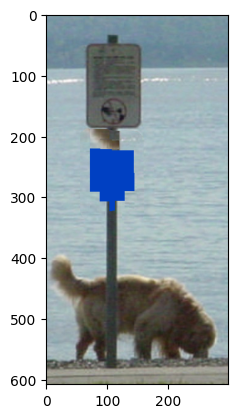

In [121]:
img_show = cv2.cvtColor(img_in_progress,cv2.COLOR_Lab2RGB)
cv2.imwrite('image_chien_res.png',img_show)
plt.imshow(img_show)